<a href="https://colab.research.google.com/github/Ptuancuong/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original: (184539, 12) labels: ['Pháp luật' 'Sức khỏe - Đời sống' 'Giáo dục' 'Thế giới' 'Thời sự'
 'Văn hóa - Giải trí' 'Thể thao' 'Xã hội' 'Bất động sản' 'Công nghệ'
 'Kinh tế' 'Kinh doanh - Tài chính' 'Bạn đọc' 'Chính trị' 'Quốc phòng'
 'Xe' 'Pháp luật']
After mapping: (152668, 12)
topic
Thời sự       49880
Giải trí      32040
Sức khỏe      25578
Thể thao      22549
Kinh doanh    18288
Công nghệ      4333
Name: count, dtype: int64
Sampled: (20000, 12)
topic
Thời sự       0.32670
Giải trí      0.20985
Sức khỏe      0.16755
Thể thao      0.14770
Kinh doanh    0.11980
Công nghệ     0.02840
Name: proportion, dtype: float64
=== Logistic Regression (bigram + oversample) ===
              precision    recall  f1-score   support

   Công nghệ       0.63      0.81      0.70       114
    Giải trí       0.67      0.84      0.74       839
  Kinh doanh       0.75      0.78      0.76       479
    Sức khỏe       0.72      0.71      0.72       670
    Thể thao       0.97      0.85      0.91     

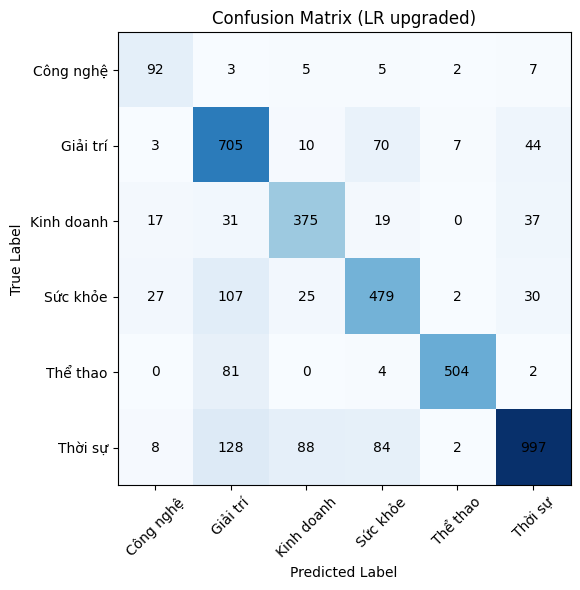

['lr_bigram_model.pkl']

In [14]:
# 1. CÀI ĐẶT THƯ VIỆN (chạy 1 lần trên Colab)
!pip install -q pandas scikit-learn

# 2. IMPORT
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.utils import resample


# 3. LOAD DATA
df = pd.read_csv('Fixed_news_dataset.csv', encoding='utf-8')
print("Original:", df.shape, "labels:", df['topic'].unique())

# 4. MAPPING NHÃN THỦ CÔNG (6 lớp)
mapping = {
    # Thời sự
    'Thời sự':'Thời sự','Chính trị':'Thời sự','Xã hội':'Thời sự',
    'Pháp luật':'Thời sự','Quốc phòng':'Thời sự',
    # Kinh doanh
    'Kinh tế':'Kinh doanh','Kinh doanh - Tài chính':'Kinh doanh','Bất động sản':'Kinh doanh',
    # Công nghệ
    'Công nghệ':'Công nghệ',
    # Thể thao
    'Thể thao':'Thể thao',
    # Giải trí
    'Văn hóa - Giải trí':'Giải trí',
    # Sức khỏe
    'Sức khỏe - Đời sống':'Sức khỏe'
}
df = df[df['topic'].isin(mapping)].copy()
df['topic'] = df['topic'].map(mapping)
print("After mapping:", df.shape)
print(df['topic'].value_counts())

# 5. SAMPLE stratified 20 000 mẫu
df_small, _ = train_test_split(
    df, train_size=20000, random_state=42, stratify=df['topic']
)
print("Sampled:", df_small.shape)
print(df_small['topic'].value_counts(normalize=True))

# 6. CLEAN & WHITESPACE-TOKENIZE
def clean(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)                       # loại HTML
    text = re.sub(r'[^0-9a-zạáàảãạâấầẩẫậăắằẳẵặèéẻẽẹêếềểễệìíỉĩị'
                  r'òóỏõọôồốổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđ\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 3. CLEAN & TOKENIZE (giữ lại whitespace-split như trước)
df_small['clean']  = df_small['content'].apply(clean)
df_small['tokens'] = df_small['clean'].str.split().apply(lambda toks: ' '.join(toks))

# 4. VECTORIZE với bigram + 10k features
vectorizer2 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_all = vectorizer2.fit_transform(df_small['tokens'])
y_all = df_small['topic']

# 5. SPLIT TRAIN/TEST stratified
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 6. (TÙY CHỌN) OVERSAMPLE trên tập train để cân bằng mỗi lớp
df_train = pd.DataFrame({'tokens': df_small.loc[y_tr.index,'tokens'], 'topic': y_tr.values})
dfs = []
max_n = df_train['topic'].value_counts().max()
for label, grp in df_train.groupby('topic'):
    dfs.append(resample(grp, replace=True, n_samples=max_n, random_state=42))
df_train_bal = pd.concat(dfs)
X_tr_bal = vectorizer2.transform(df_train_bal['tokens'])
y_tr_bal = df_train_bal['topic']

# 7. TRAIN Logistic Regression (cân bằng class_weight)
lr2 = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    C=1.0,
    max_iter=1000,
    random_state=42
)
lr2.fit(X_tr_bal, y_tr_bal)

# 8. EVAL trên tập test
y_pred2 = lr2.predict(X_te)
print("=== Logistic Regression (bigram + oversample) ===")
print(classification_report(y_te, y_pred2))

# 9. CONFUSION MATRIX
cm2 = confusion_matrix(y_te, y_pred2, labels=lr2.classes_)
plt.figure(figsize=(6,6))
plt.imshow(cm2, cmap='Blues')
plt.title('Confusion Matrix (LR upgraded)')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(range(len(lr2.classes_)), lr2.classes_, rotation=45)
plt.yticks(range(len(lr2.classes_)), lr2.classes_)
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(j, i, cm2[i,j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 10. LƯU model & vectorizer mới
joblib.dump(vectorizer2, 'tfidf_bigram_10k.pkl')
joblib.dump(lr2, 'lr_bigram_model.pkl')


In [17]:
# Định nghĩa lại hàm predict_topic
def predict_topic(text):
    # Dùng đúng hàm clean và vectorizer/model bạn đã train
    txt = clean(text)                       # hàm clean đã định nghĩa trước
    toks = ' '.join(txt.split())            # whitespace-tokenize
    vec  = vectorizer2.transform([toks])    # vectorizer2 từ cell TF-IDF bigram
    return lr2.predict(vec)[0]              # lr2 là model Logistic Regression nâng cấp


In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

inp = widgets.Textarea(
    value='',
    placeholder='Nhập văn bản để phân loại...',
    description='Văn bản:',
    layout=widgets.Layout(width='80%', height='100px')
)
btn = widgets.Button(description='Dự đoán chủ đề')
out = widgets.Output(layout=widgets.Layout(border='1px solid gray'))

def on_click(b):
    with out:
        clear_output()
        text = inp.value.strip()
        if text:
            topic = predict_topic(text)
            print(f"→ Nhãn dự đoán: **{topic}**")
        else:
            print("Hãy nhập một đoạn văn bản!")

btn.on_click(on_click)
display(inp, btn, out)


Textarea(value='', description='Văn bản:', layout=Layout(height='100px', width='80%'), placeholder='Nhập văn b…

Button(description='Dự đoán chủ đề', style=ButtonStyle())

Output(layout=Layout(border='1px solid gray'))